# Initialization

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# Загрузка данных

In [3]:
items = pd.read_parquet("items.par")
events = pd.read_parquet("events.par")

# Разбиение с учётом хронологии

Рекомендательные системы на практике работают с учётом хронологии. Поэтому поток событий для тренировки и валидации полезно делить на то, что уже случилось, и что ещё случится. Это позволяет проводить валидацию на тех же пользователях, на которых тренировались, но на их событиях в будущем.

# === Знакомство: "холодный" старт

In [4]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users  = set(users_train).intersection(set(users_test))

# print(len(users_train), len(users_test), len(common_users))
print(f'Кол-во пользователей в train: {len(users_train)}')
print(f'Кол-во пользователей в test: {len(users_test)}')
print(f'Кол-во пользователей, которые есть и в train, и в test: {len(common_users)}')

Кол-во пользователей в train: 428220
Кол-во пользователей в test: 123223
Кол-во пользователей, которые есть и в train, и в test: 120858


In [5]:
# Второй вариант:


# Разделяем данные по дате "2017-08-01"
split_date = pd.to_datetime("2017-08-01").date()

# Обучающая выборка (данные ДО split_date)
train_data = events[events["started_at"] < split_date]

# Тестовая выборка (данные ПОСЛЕ split_date)
test_data = events[events["started_at"] >= split_date]  # вместо ~ можно явно указать >=

# Уникальные пользователи в train и test
train_users = train_data["user_id"].unique()  # проще, чем drop_duplicates()
test_users = test_data["user_id"].unique()

# Пользователи, которые есть в обоих выборках
common_users = set(train_users) & set(test_users)  # альтернатива intersection

print(
    f"Пользователей в train: {len(train_users)}\n"
    f"Пользователей в test: {len(test_users)}\n"
    f"Общих пользователей: {len(common_users)}"
)

Пользователей в train: 428220
Пользователей в test: 123223
Общих пользователей: 120858


In [6]:
# Идентифицируйте холодных пользователей и оцените их количество.

cold_users = set(users_test) - set(users_train)
print(f"Холодных пользователей: {len(cold_users)}\n")

Холодных пользователей: 2365



# === Знакомство: первые персональные рекомендации

Ключевые моменты:
Фильтрация по дате: Берем только события с 2015 года

Группировка и агрегация:
    - users - количество уникальных пользователей для каждой книги
    - avg_rating - средний рейтинг книги

Нормализация:
Приводим метрики к единому масштабу (0-1) для корректного объединения

Popularity Score:
Комбинированная метрика = нормированное кол-во пользователей × нормированный рейтинг

Финальный отбор:
- Сначала фильтруем по рейтингу (>= 4)
- Затем берем топ-100 по popularity_score

Этот подход обеспечивает рекомендации, которые одновременно:
- Популярны (много пользователей взаимодействовали)
- Качественны (высокий средний рейтинг)
- Актуальны (учитываются только свежие данные с 2015 года)

In [7]:
from sklearn.preprocessing import MinMaxScaler

top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_rating"]]
)

# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
)

# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by = 'popularity_score', ascending = False)

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity[item_popularity['avg_rating'] > 4].head(100)

In [8]:
top_k_pop_items

,item_id,users,avg_rating,users_norm,avg_rating_norm,popularity_score
32387,18007564,20207,4.321275,0.496596,0.830319,0.412333
32623,18143977,19462,4.290669,0.478287,0.822667,0.393471
2,3,15139,4.706057,0.372042,0.926514,0.344702
30695,16096824,16770,4.301014,0.412126,0.825253,0.340108
1916,15881,13043,4.632447,0.320529,0.908112,0.291076
...,...,...,...,...,...,...
24837,8490112,4792,4.080968,0.117747,0.770242,0.090694
33611,18966819,4361,4.374914,0.107154,0.843729,0.090409
378,3636,4667,4.098564,0.114675,0.774641,0.088832
32835,18293427,4674,4.092640,0.114847,0.773160,0.088795


In [9]:
# Сколько пользователей оценило книгу, попавшую на первое место в top_k_pop_items?

if not top_k_pop_items.empty:
    top_item_users = top_k_pop_items.iloc[0]["users"]
    print(f"Книга №1 в топ-100 была оценена {top_item_users} пользователями.")
else:
    print("Топ-100 пуст — возможно, нет книг с рейтингом ≥ 4.")

Книга №1 в топ-100 была оценена 20207.0 пользователями.


Добавив информацию о книгах, можно просмотреть, какие попали в топ.

In [10]:
# добавляем информацию о книгах
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["author", "title", "genre_and_votes", "publication_year"]], on="item_id")

with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "author", "title", "publication_year", "users", "avg_rating", "popularity_score", "genre_and_votes"]]) 

,item_id,author,title,publication_year,users,avg_rating,popularity_score,genre_and_votes
0,18007564,Andy Weir,The Martian,2014,20207,4.321275,0.412333,"{'Science Fiction': 11966, 'Fiction': 8430}"
1,18143977,Anthony Doerr,All the Light We Cannot See,2014,19462,4.290669,0.393471,"{'Historical-Historical Fiction': 13679, 'Fict..."
2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,15139,4.706057,0.344702,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,16096824,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,2015,16770,4.301014,0.340108,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman..."
4,15881,"J.K. Rowling, Mary GrandPré",Harry Potter and the Chamber of Secrets (Harry...,1999,13043,4.632447,0.291076,"{'Fantasy': 50130, 'Young Adult': 15202, 'Fict..."
5,38447,Margaret Atwood,The Handmaid's Tale,1998,14611,4.232770,0.290194,"{'Fiction': 15424, 'Classics': 9937, 'Science ..."
6,11235712,Marissa Meyer,"Cinder (The Lunar Chronicles, #1)",2012,14348,4.179189,0.280247,"{'Young Adult': 10539, 'Fantasy': 9237, 'Scien..."
7,17927395,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...,2016,12177,4.730640,0.279094,"{'Fantasy': 10186, 'Romance': 3346, 'Young Adu..."
8,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,2004,11890,4.770143,0.275401,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
9,13206900,Marissa Meyer,"Winter (The Lunar Chronicles, #4)",2015,12291,4.534293,0.266881,"{'Fantasy': 4835, 'Young Adult': 4672, 'Scienc..."


In [11]:
# # Объедините event_test с top_k_pop_items, чтобы получить рекомендации для холодных пользователей
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items, on="item_id", how="left")

cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "item_id", "rating", "avg_rating"]] 

# Проверьте количество строк, чтобы убедиться, что оно осталось прежним
original_row_count = len(events_test[events_test["user_id"].isin(cold_users)])
current_row_count = len(cold_users_events_with_recs)

# Проверяем, одинаково ли количество строк
original_row_count, current_row_count

(9672, 9672)

In [12]:
# 1. Объединяем events_test с топ-100 книгами (только для холодных пользователей)
cold_users_events_with_recs = (
    events_test[events_test["user_id"].isin(cold_users)]
    .merge(top_k_pop_items, on="item_id", how="left")
)

# 2. Фильтруем только книги из топ-100 (avg_rating не NaN)
cold_user_recs = cold_users_events_with_recs[
    ~cold_users_events_with_recs["avg_rating"].isnull()
][["user_id", "item_id", "rating", "avg_rating"]]

# 3. Проверяем, что merge не изменил количество строк
original_row_count = len(events_test[events_test["user_id"].isin(cold_users)])
current_row_count = len(cold_users_events_with_recs)

# Вывод результатов
print(
    f"Исходное количество записей холодных пользователей: {original_row_count}\n"
    f"Количество записей после merge: {current_row_count}\n"
    f"Осталось записей после фильтрации (топ-100 книг): {len(cold_user_recs)}"
)

Исходное количество записей холодных пользователей: 9672
Количество записей после merge: 9672
Осталось записей после фильтрации (топ-100 книг): 1912


In [13]:
# Проверка равенства (должно быть True)
assert original_row_count == current_row_count, "Количество строк изменилось после merge!"
print("✅ Проверка пройдена: merge не изменил количество строк.")

✅ Проверка пройдена: merge не изменил количество строк.


In [14]:
# Для какой доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items совпали по книгам? Округлите ответ до сотых.

# 1. События холодных пользователей
cold_events = events_test[events_test["user_id"].isin(cold_users)]

# 2. Совпадения с топ-100 книгами
matched_events = cold_events[cold_events["item_id"].isin(top_k_pop_items["item_id"])]

# 3. Доля совпадений (с округлением)
match_ratio = len(matched_events) / len(cold_events)
match_ratio_rounded = round(match_ratio, 2)

print(f"Доля событий холодных пользователей с книгами из топ-100: {match_ratio_rounded:.2f}")

Доля событий холодных пользователей с книгами из топ-100: 0.20


In [15]:
# Посчитайте метрики rmse и mae для полученных рекомендаций.

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Рассчитываем метрики
rmse = mean_squared_error(cold_user_recs["rating"], cold_user_recs["avg_rating"], squared=False)
mae = mean_absolute_error(cold_user_recs["rating"], cold_user_recs["avg_rating"])

# Красивый вывод с f-строками
print(f"Оценка качества рекомендаций для холодных пользователей:")
print(f"• RMSE (Среднеквадратичная ошибка): {rmse:.2f}")
print(f"• MAE (Средняя абсолютная ошибка): {mae:.2f}")
print(f"\nИнтерпретация:")
print(f"- RMSE = {rmse:.2f} означает, что в среднем ошибка составляет ±{rmse:.2f} балла")
print(f"- MAE = {mae:.2f} показывает среднее абсолютное отклонение предсказаний")

Оценка качества рекомендаций для холодных пользователей:
• RMSE (Среднеквадратичная ошибка): 0.78
• MAE (Средняя абсолютная ошибка): 0.62

Интерпретация:
- RMSE = 0.78 означает, что в среднем ошибка составляет ±0.78 балла
- MAE = 0.62 показывает среднее абсолютное отклонение предсказаний


In [16]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


In [17]:
# Оцените степень разреженности U-I-матрицы, построенной на основе events. 

# Уникальные пользователи и товары
n_users = events['user_id'].nunique()
n_items = events['item_id'].nunique()

# Количество реальных оценок
n_ratings = len(events)

# Общее возможное взаимодействий
total_possible = n_users * n_items

# Степень разреженности (в %)
sparsity = (1 - n_ratings / total_possible) * 100

print(
    f"Уникальные пользователи: {n_users:,}\n"
    f"Уникальные товары: {n_items:,}\n"
    f"Количество оценок: {n_ratings:,}\n"
    f"Разреженность матрицы: {sparsity:.2f}%"
)

Уникальные пользователи: 430,585
Уникальные товары: 41,673
Количество оценок: 11,751,086
Разреженность матрицы: 99.93%


# === Базовые подходы: коллаборативная фильтрация

In [18]:
# Воспользуемся готовой реализацией SVD-алгоритма из библиотеки surprise. В качестве разбиения данных на train и test возьмём разбиение из предыдущего урока: events_train, events_test.

from surprise import Dataset, Reader
from surprise import SVD

# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
reader = Reader(rating_scale=(1, 5))
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'rating']], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

In [19]:
# Используя обученную модель, получим рекомендации для тестовой выборки:

surprise_test_set = list(events_test[['user_id', 'item_id', 'rating']].itertuples(index=False))

# получаем рекомендации для тестовой выборки
svd_predictions = svd_model.test(surprise_test_set)

In [20]:
# Полученные рекомендации можно оценить, используя встроенный модуль accuracy из библиотеки surprise:

from surprise import accuracy

rmse_svd = accuracy.rmse(svd_predictions)
mae_svd = accuracy.mae(svd_predictions)
                     
print(rmse_svd, mae_svd)

RMSE: 0.8259
MAE:  0.6458
0.8259326543219302 0.6458324731790988


In [21]:
# Проверка метрик на адекватность
# Понять, хороши или плохи полученные значения метрик, поможет проверка на адекватность (англ. sanity check). Например, сравним качество рекомендаций со случайными по тем же метрикам. 
# Для генерации случайных рекомендаций библиотека surprise предлагает класс NormalPredictor, который выдаёт случайные рейтинги из нормального распределения. Вызывается он так:

from surprise import NormalPredictor

# инициализируем состояние генератора, это необходимо для получения
# одной и той же последовательности случайных чисел, только в учебных целях
np.random.seed(0)

random_model = NormalPredictor()

random_model.fit(surprise_train_set)
random_predictions = random_model.test(surprise_test_set)

In [22]:
# Рассчитайте значение MAE для random_predictions

rmse_np = accuracy.rmse(random_predictions)
mae_np = accuracy.mae(random_predictions)
                     
print(rmse_np, mae_np)

RMSE: 1.2608
MAE:  0.9999
1.2607921290603934 0.9998705396950534


In [23]:
# На сколько процентов MAE для случайных рекомендаций от NormalPredictor выше значения MAE от SVD?

difference_percent = ((mae_np - mae_svd) / mae_svd) * 100
print(f"MAE NormalPredictor выше на {round(difference_percent)}%")

MAE NormalPredictor выше на 55%


_____________________________________________________________________________________________________________________________________________________________________________________________________________

Факультативное задание
Удалите из events события для редких айтемов — таких, с которыми взаимодействовало менее N пользователей. 
Возьмите небольшое N, например 2–3 пользователя. Получите рекомендации, посчитайте метрики, оцените, как они изменились. Подумайте, с чем могут быть связаны такие изменения.

Вывод
Фильтрация редких айтемов   = 52 улучшила MAE на 0~5%, так как модель перестала учитывать шумовые данные. Однако это может снизить разнообразие рекомендаций. Оптимальное N выбирается в зависимости от задач системы.

Причины такого распределения  
    - 
Утечка данных: В тест попали преимущественно редкие айтем  ы    - 

Некорректное разбиение: Стратификация по пользователям, но не по айте  м    - м

Особенности предметной области: Например, тест содержит "нов  

Для данных N нужно выбирать по трейну:  
    - 
N=50 (медиана популярности в трейне ~4  6    - 

N=174 (75%-й перцент  иль)инки"

_________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [24]:
events_test

,user_id,item_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month
50,1000003,25893709,2017-10-05,2017-10-17,True,4,False,2017-10-01
263,1000005,34076952,2017-10-09,2017-10-24,True,5,False,2017-10-01
285,1000006,18812405,2017-08-05,2017-08-19,True,3,False,2017-08-01
290,1000006,7445,2017-08-26,2017-08-30,True,4,False,2017-08-01
294,1000006,29868610,2017-08-30,2017-09-16,True,4,False,2017-08-01
...,...,...,...,...,...,...,...,...
11751007,1430579,27272506,2017-09-03,2017-10-07,True,3,True,2017-09-01
11751058,1430580,22021611,2017-10-05,2017-10-05,True,4,False,2017-10-01
11751059,1430580,15749186,2017-10-05,2017-10-18,True,4,False,2017-10-01
11751073,1430584,18692431,2017-08-02,2017-08-09,True,3,True,2017-08-01


In [25]:
# получить оценку для пользователя user_id и айтема item_id поможет метод predict
svd_model.predict("1000003","34076952")

Prediction(uid='1000003', iid='34076952', r_ui=None, est=3.9459914088879833, details={'was_impossible': False})

In [26]:
set(events_test[events_test["user_id"]==1000006]['item_id'].unique())

{7445, 18774964, 18812405, 24817626, 29868610}

In [27]:
# Создайте функцию, которая позволит получить рекомендации для конкретного пользователя, используя описанный подход.

def get_recommendations_svd(user_id, all_items, events, model, include_seen=True, n=5):
    """Возвращает n рекомендаций для user_id."""
    
    # Получаем список идентификаторов всех книг
    all_items = set(events['item_id'].unique())
        
    # Учитываем флаг, стоит ли включать уже прочитанные книги
    if include_seen:
        items_to_predict = list(all_items)
    else:
        # Получаем книги, которые пользователь уже прочитал (только для текущего user_id!)
        seen_items = set(events[events['user_id'] == user_id]['item_id'].unique())
        
        # Оставляем только непрочитанные книги
        items_to_predict = list(all_items - seen_items)
    
    # Получаем предсказания модели для каждого item_id
    predictions = [model.predict(user_id, item_id) for item_id in items_to_predict]
    
    # Сортируем по убыванию оценки (est) и берём топ-n
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Возвращаем DataFrame с item_id и их оценками
    return pd.DataFrame([(pred.iid, pred.est) for pred in recommendations], 
                       columns=["item_id", "score"])

In [28]:
# Получаем рекомендации
recs = get_recommendations_svd(1296647, items, events_train, svd_model)

# Берем третий item_id (индекс 2, так как индексация с 0)
third_rec_item_id = recs.iloc[2]['item_id']
print(f"Item ID третьей рекомендации: {third_rec_item_id}")

Item ID третьей рекомендации: 30688013.0


In [29]:
get_recommendations_svd(1296647, items, events_test, svd_model)

,item_id,score
0,323355,4.988212
1,30688013,4.975064
2,11737700,4.972143
3,6898978,4.960511
4,22037424,4.955417


In [30]:
get_recommendations_svd(1296647, items, events_train, svd_model)

,item_id,score
0,24812,5.000000
1,323355,4.988212
2,30688013,4.975064
3,11737700,4.972143
4,6898978,4.960511


Дополнительная проверка качества рекомендаций

In [31]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

user_id: 1109853


In [32]:
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["author", "title", "genre_and_votes"]], on="item_id")
)
user_history_to_print = user_history[["author", "title", "started_at", "read_at", "rating", "genre_and_votes"]].tail(10)
display(user_history_to_print)

История (последние события, recent)


,author,title,started_at,read_at,rating,genre_and_votes
0,Patrick Rothfuss,"The Wise Man's Fear (The Kingkiller Chronicle,...",2015-06-17,2015-08-31,5,"{'Fantasy': 16491, 'Fiction': 2222, 'Fantasy-E..."
1,Brandon Sanderson,"The Way of Kings (The Stormlight Archive, #1)",2015-08-31,2015-10-30,5,"{'Fantasy': 14291, 'Fiction': 1623, 'Fantasy-E..."
2,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",2015-10-30,2016-03-17,5,"{'Fantasy': 8542, 'Fiction': 872, 'Fantasy-Epi..."
3,Andy Weir,The Martian,2014-12-07,2014-12-11,4,"{'Science Fiction': 11966, 'Fiction': 8430}"
4,Ken Follett,"Fall of Giants (The Century Trilogy, #1)",2016-05-12,2016-08-30,4,"{'Historical-Historical Fiction': 4665, 'Ficti..."


In [33]:
print("Рекомендации")
user_recommendations = get_recommendations_svd(user_id, items, events_train, svd_model)
user_recommendations = user_recommendations.merge(items[["item_id", "author", "title", "genre_and_votes"]], on="item_id")
display(user_recommendations) 

Рекомендации


,item_id,score,author,title,genre_and_votes
0,24813,5.000000,Bill Watterson,The Calvin and Hobbes Tenth Anniversary Book,"{'Sequential Art-Comics': 784, 'Humor': 377, '..."
1,11221285,5.000000,Brandon Sanderson,"The Way of Kings, Part 2 (The Stormlight Archi...","{'Fantasy': 641, 'Fiction': 46, 'Fantasy-Epic ..."
2,19219646,5.000000,Wolfgang Herrndorf,Arbeit und Struktur,"{'Nonfiction': 25, 'European Literature-German..."
3,7864312,5.000000,José Antonio Cotrina,La sombra de la luna (El ciclo de la luna roja...,"{'Fantasy': 20, 'Young Adult': 7}"
4,33353628,4.959447,Pénélope Bagieu,"Culottées #2 (Culottées, #2)","{'Sequential Art-Bande DessinÃ©e': 108, 'Femin..."


In [34]:
user_recommendations

,item_id,score,author,title,genre_and_votes
0,24813,5.000000,Bill Watterson,The Calvin and Hobbes Tenth Anniversary Book,"{'Sequential Art-Comics': 784, 'Humor': 377, '..."
1,11221285,5.000000,Brandon Sanderson,"The Way of Kings, Part 2 (The Stormlight Archi...","{'Fantasy': 641, 'Fiction': 46, 'Fantasy-Epic ..."
2,19219646,5.000000,Wolfgang Herrndorf,Arbeit und Struktur,"{'Nonfiction': 25, 'European Literature-German..."
3,7864312,5.000000,José Antonio Cotrina,La sombra de la luna (El ciclo de la luna roja...,"{'Fantasy': 20, 'Young Adult': 7}"
4,33353628,4.959447,Pénélope Bagieu,"Culottées #2 (Culottées, #2)","{'Sequential Art-Bande DessinÃ©e': 108, 'Femin..."


# === Коллаборативная фильтрация: ALS

In [35]:
# Получим рекомендации с помощью алгоритма ALS из библиотеки implicit. Схема действий такая:
# 1.Перекодировать идентификаторы пользователей и объектов.
# 2.Явно подготовить матрицу взаимодействий.
# 3.Провести тренировку модели с помощью ALS на тренировочной части данных.
# 4.На основе полученной модели сгенерировать рекомендации.
# 5.Оценить полученные рекомендации.

import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_2405/105635403.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_2405/105635403.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_2405/105635403.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [36]:
#Какое максимальное значение получилось для events_train[’item_id_enc']?

events_train['item_id_enc'].max()

43304

In [37]:
# Вычислите размер матрицы user_item_matrix_train, как если бы она хранила все свои элементы, включая пропуски, и для каждого элемента использовался бы один байт. Ответ приведите в виде целого числа гигабайтов, отбросив дробную часть.
# Подсказка: 
# Умножьте количество строк на количество столбцов, а затем результат разделите на 1024**3.

# Подсчёт количества уникальных пользователей и товаров
n_users = events_train['user_id_enc'].nunique()
n_items = events_train['item_id_enc'].nunique()

print("Количество уникальных пользователей:", n_users)
print("Количество уникальных товаров:", n_items)

# Вычисление размера матрицы в гигабайтах (1 байт на элемент)
matrix_size_gb = (n_users * n_items) / (1024 ** 3)

# Отбрасывание дробной части (целочисленное деление)
matrix_size_gb_int = int(matrix_size_gb)

print(f"Размер user_item_matrix_train: {matrix_size_gb_int} ГБ")

Количество уникальных пользователей: 428220
Количество уникальных товаров: 41474
Размер user_item_matrix_train: 16 ГБ


In [38]:
matrix_size_gb_rounded = round(matrix_size_gb)
print(f"Размер: {matrix_size_gb_rounded} ГБ")

Размер: 17 ГБ


In [39]:
# Cоздадим sparse-матрицу в формате CSR. Такая матрица хранит только имеющиеся значения и не резервирует память под пропуски. 
# Это помогает значительно сэкономить оперативную память при работе с разреженными матрицами.

user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [40]:
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 11326124 stored elements and shape (430585, 43305)>

In [41]:
# sparse-формат numpy-матриц позволяет сильно уменьшить требование к размеру памяти. Можно самостоятельно посчитать и сравнить, используя код ниже:

import sys

hd = sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3 

print(f"Размер: {round(hd, 2)} ГБ")

Размер: 0.26 ГБ


In [42]:
# Имея подготовленную матрицу взаимодействий, перейдём к третьему шагу — создадим ALS-модель. Для примера возьмём количество латентных факторов для матриц $P, Q$, равным 50

from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/mle-recsys-start/.env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle_projects/mle-recsys-start/.env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


In [43]:
# Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [44]:
get_recommendations_als(user_item_matrix_train, als_model, 1296647, user_encoder, item_encoder, include_seen=True, n=5)

,item_id_enc,score,item_id
0,27664,0.900511,9460487
1,38878,0.864551,22557272
2,1641,0.784544,13496
3,29910,0.691194,11870085
4,6942,0.679302,99561


_______________________________________________________________________________________________________________________________________________________________________________________

Факультативное задание
Используя get_recommendations_als, напишите код, который позволит для случайного пользователя просмотреть рекомендации в удобном формате: 
история с именами авторов и названием книг,
рекомендации с именами авторов и названием книг, seen-признаком (взаимодействовал ли уже пользователь с рекомендованной книгой).

In [45]:
def analyze_als_recommendations(user_item_matrix, model, user_encoder, item_encoder, items, events_train, n_recommendations=5):
    """
    Анализ рекомендаций для случайного пользователя с историей и seen-признаком
    """
    # 1. Выбираем случайного пользователя с историей
    active_users = np.unique(events_train['user_id'])
    user_id = np.random.choice(active_users)
    user_id_enc = user_encoder.transform([user_id])[0]
    
    print(f"Анализ для user_id: {user_id} (encoded: {user_id_enc})")
    
    # 2. Получаем историю пользователя (только с доступными столбцами)
    available_columns = ['author', 'title', 'rating', 'started_at']  # Только существующие столбцы
    user_history = (
        events_train[events_train['user_id'] == user_id]
        .merge(items, on='item_id')
        [available_columns]
        .sort_values('started_at', ascending=False)
    )
    
    print("\nИстория чтения (последние книги):")
    display(user_history.head(10))
    
    # 3. Получаем рекомендации
    recommendations = get_recommendations_als(
        user_item_matrix, 
        model, 
        user_id, 
        user_encoder, 
        item_encoder,
        include_seen=False,
        n=n_recommendations
    )
    
    # 4. Добавляем информацию о книгах (только доступные столбцы)
    recommendations = recommendations.merge(
        items[['item_id', 'author', 'title']],  # Только существующие столбцы
        on='item_id',
        how='left'
    )
    
    # Добавляем признак "уже взаимодействовал"
    seen_items = set(events_train[events_train['user_id'] == user_id]['item_id'])
    recommendations['seen'] = recommendations['item_id'].isin(seen_items)
    
    print(f"\nТоп-{n_recommendations} рекомендаций:")
    display(recommendations[['title', 'author', 'score', 'seen']])
    
    # 5. Упрощенный анализ релевантности (без жанров)
    if not user_history.empty:
        # Средний рейтинг пользователя
        avg_rating = user_history['rating'].mean()
        
        print("\nАнализ релевантности:")
        print(f"- Средний рейтинг пользователя: {avg_rating:.1f}/5")
        print(f"- Средний score рекомендаций: {recommendations['score'].mean():.2f}")
        print(f"- Уже прочитано книг из рекомендаций: {recommendations['seen'].sum()}/{n_recommendations}")

# Пример использования
analyze_als_recommendations(
    user_item_matrix_train,
    als_model,
    user_encoder,
    item_encoder,
    items,
    events_train,
    n_recommendations=5
)

Анализ для user_id: 1355064 (encoded: 355064)

История чтения (последние книги):


,author,title,rating,started_at
1,Grace Helbig,Grace's Guide: The Art of Pretending to Be a G...,3,2015-03-28
0,Miranda Hart,Is It Just Me?,4,2014-05-30



Топ-5 рекомендаций:


,title,author,score,seen
0,Harry Potter and the Cursed Child - Parts One ...,"John Tiffany, Jack Thorne, J.K. Rowling",0.031604,False
1,Yes Please,Amy Poehler,0.026326,False
2,How to Be a Woman,Caitlin Moran,0.024624,False
3,Is Everyone Hanging Out Without Me?,Mindy Kaling,0.023491,False
4,The Casual Vacancy,J.K. Rowling,0.023135,False



Анализ релевантности:
- Средний рейтинг пользователя: 3.5/5
- Средний score рекомендаций: 0.03
- Уже прочитано книг из рекомендаций: 0/5


In [46]:
events_train

,user_id,item_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month,user_id_enc,item_id_enc
0,1000000,5350,2016-03-18,2016-04-03,True,4,False,2016-03-01,0,611
1,1000000,6748,2016-04-16,2016-04-30,True,5,False,2016-04-01,0,783
2,1000000,17675462,2016-07-06,2016-07-15,True,5,False,2016-07-01,0,35259
3,1000000,25494343,2016-06-10,2016-07-06,True,4,False,2016-06-01,0,40673
4,1000000,17851885,2016-08-01,2016-08-09,True,4,False,2016-08-01,0,35502
...,...,...,...,...,...,...,...,...,...,...
11751081,1430584,7896527,2016-05-18,2016-06-03,True,4,True,2016-05-01,430584,26313
11751082,1430584,29056083,2016-08-01,2016-08-03,True,3,True,2016-08-01,430584,41809
11751083,1430584,6614960,2015-11-02,2015-12-25,True,3,False,2015-11-01,430584,24432
11751084,1430584,3153910,2014-06-11,2014-07-01,True,5,False,2014-06-01,430584,21409


In [47]:
def analyze_als_recommendations(user_item_matrix, model, user_encoder, item_encoder, items, events_train, n_recommendations=5):
    """
    Анализ рекомендаций для случайного пользователя с историей и seen-признаком
    """
    # 1. Выбираем случайного пользователя с историей
    active_users = np.unique(events_train['user_id'])
    user_id = np.random.choice(active_users)
    user_id_enc = user_encoder.transform([user_id])[0]
    
    print(f"Анализ для user_id: {user_id} (encoded: {user_id_enc})")
    
    # 2. Получаем историю пользователя
    user_history = (
        events_train[events_train['user_id'] == user_id]
        .sort_values('started_at', ascending=False)
        .head(10)  # Последние 10 прочитанных книг
    )
    
    # Добавляем информацию о книгах (если есть)
    if 'title' in items.columns and 'author' in items.columns:
        user_history = user_history.merge(
            items[['item_id', 'title', 'author']], 
            on='item_id',
            how='left'
        )
    
    print("\nИстория чтения (последние книги):")
    display(user_history[['item_id', 'title', 'author', 'rating', 'started_at'] 
            if 'title' in user_history.columns 
            else ['item_id', 'rating', 'started_at']])
    
    # 3. Получаем рекомендации
    recommendations = get_recommendations_als(
        user_item_matrix, 
        model, 
        user_id, 
        user_encoder, 
        item_encoder,
        include_seen=False,
        n=n_recommendations
    )
    
    # 4. Добавляем информацию о книгах (если есть)
    if 'title' in items.columns and 'author' in items.columns:
        recommendations = recommendations.merge(
            items[['item_id', 'title', 'author']],
            on='item_id',
            how='left'
        )
    
    # Добавляем признак "уже взаимодействовал"
    seen_items = set(events_train[events_train['user_id'] == user_id]['item_id'])
    recommendations['seen'] = recommendations['item_id'].isin(seen_items)
    
    print(f"\nТоп-{n_recommendations} рекомендаций:")
    display(recommendations[['item_id', 'title', 'author', 'score', 'seen']] 
           if 'title' in recommendations.columns 
           else ['item_id', 'score', 'seen'])
    
    # 5. Анализ релевантности
    if not user_history.empty:
        avg_rating = user_history['rating'].mean()
        
        print("\nАнализ релевантности:")
        print(f"- Средний рейтинг пользователя: {avg_rating:.1f}/5")
        print(f"- Средний score рекомендаций: {recommendations['score'].mean():.2f}")
        print(f"- Уже прочитано книг из рекомендаций: {recommendations['seen'].sum()}/{n_recommendations}")

# Пример использования
analyze_als_recommendations(
    user_item_matrix_train,
    als_model,
    user_encoder,
    item_encoder,
    items,
    events_train,
    n_recommendations=5
)

Анализ для user_id: 1015845 (encoded: 15845)

История чтения (последние книги):


,item_id,title,author,rating,started_at
0,17927395,A Court of Mist and Fury (A Court of Thorns an...,Sarah J. Maas,5,2017-02-20
1,23009402,Saint Anything,Sarah Dessen,4,2016-09-18
2,15777621,This Song Will Save Your Life,Leila Sales,5,2013-12-29
3,8909152,Attachments,Rainbow Rowell,4,2013-12-26
4,12882683,"Whirl (Ondine Quartet, #1)",Emma Raveling,4,2013-11-17
5,16068905,Fangirl,Rainbow Rowell,5,2013-11-15
6,345627,"Vampire Academy (Vampire Academy, #1)",Richelle Mead,4,2013-09-27
7,17167166,"Crown of Midnight (Throne of Glass, #2)",Sarah J. Maas,5,2013-09-03
8,10429067,"Sweet Venom (Medusa Girls, #1)",Tera Lynn Childs,4,2013-08-07
9,3236307,"Graceling (Graceling Realm, #1)",Kristin Cashore,5,2013-04-14



Топ-5 рекомендаций:


,item_id,title,author,score,seen
0,7171637,"Clockwork Angel (The Infernal Devices, #1)",Cassandra Clare,0.823620,False
1,10025305,"Clockwork Prince (The Infernal Devices, #2)",Cassandra Clare,0.792809,False
2,20613470,"Heir of Fire (Throne of Glass, #3)",Sarah J. Maas,0.791482,False
3,16096824,A Court of Thorns and Roses (A Court of Thorns...,Sarah J. Maas,0.758448,False
4,3777732,"City of Glass (The Mortal Instruments, #3)",Cassandra Clare,0.707523,False



Анализ релевантности:
- Средний рейтинг пользователя: 4.5/5
- Средний score рекомендаций: 0.77
- Уже прочитано книг из рекомендаций: 0/5


______________________________________________________________________________________________________________________________________________________________

In [48]:
# Получим рекомендации для всех имеющихся пользователей. Выполните код ниже.

# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

In [49]:
# Код возвращает рекомендации как список списков, это не очень удобно. Преобразуем его в более удобный формат — табличный.

# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [50]:
als_recommendations.head()

,score,user_id,item_id
0,0.990941,1000000,3
1,0.896617,1000000,15881
2,0.864404,1000000,5
3,0.822254,1000000,6
4,0.774095,1000000,2


In [51]:
# Сохраним полученные рекомендации в файл, они ещё нам пригодятся.

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("als_recommendations.parquet")

In [52]:
# Для удобства оценки добавим в датафрейм с рекомендациями истинные оценки из тестовой выборки

als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "item_id", "rating"]]
               .rename(columns={"rating": "rating_test"}), 
           on=["user_id", "item_id"], how="left")
)

In [53]:
als_recommendations.head()

,user_id,item_id,score,rating_test
0,1000000,3,0.990941,NaN
1,1000000,15881,0.896617,NaN
2,1000000,5,0.864404,NaN
3,1000000,6,0.822254,NaN
4,1000000,2,0.774095,NaN


In [54]:
# Подсчитать метрику NDCG для одного пользователя поможет готовая реализация из scikit-learn:

import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

In [55]:
# Умея считать NDCG для одного пользователя, посчитаем данную метрику, например, для k=5 для всех пользователей из тестовой выборки. 
# В результате каждому пользователю будет соответствовать одно значение NDCG@5. Запись “NDCG@5” означает, что метрика NDCG считается для пяти объектов.

rating_test_idx = ~als_recommendations["rating_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5))

In [56]:
# Имея ряд значений NDCG@5 по пользователям, можно посчитать среднее её значение (по всем пользователям):

print(ndcg_at_5_scores.mean())

0.975946709792109


In [57]:
ndcg_at_5_scores

user_id
1000006    1.0
1000007    NaN
1000019    NaN
1000020    NaN
1000023    1.0
          ... 
1430558    NaN
1430569    1.0
1430573    NaN
1430578    1.0
1430584    NaN
Length: 48135, dtype: float64

________________________________________________________________________________________________________________________________________________________________________

Факультативное задание  
    - Оцените, для какой доли пользователей удалось посчитать метрику NDCG.  

В качестве факультативного материала кратко расскажем о двух видах рекомендаций — l2l и U2U. Ознакомиться с ними подробнее вы сможете по прикреплённым ниже внешним ссылками.
Рекомендации I2I  
Рекомендации вида I2I — это рекомендации похожих объектов. Например, к некоторой книге порекомендовать список похожих книг. Рассматриваемая реализация ALS позволяет получить такие рекомендации при помощи метода similar_items (описание).    

Факультативное задание  
    - Используя метод  similar_items, получите и оцените рекомендации для нескольких айтемов. Проанализируйте адекватность результатов.

In [58]:
# Рассчитываем долю пользователей с доступными тестовыми оценками
users_with_ndcg = ndcg_at_5_scores.notna().sum()
total_users = len(user_encoder.classes_)
coverage = users_with_ndcg / total_users

print(f"Метрика NDCG@5 рассчитана для {users_with_ndcg} из {total_users} пользователей")
print(f"Покрытие: {coverage:.1%}")

Метрика NDCG@5 рассчитана для 17236 из 430585 пользователей
Покрытие: 4.0%


Интерпретация:  
Обычно покрытие 30-70% - хороший результат. Если <20%, стоит пересмотреть разбиение данных.

Анализ качества:  

- Проверьте, что рекомендации:  
    - Принадлежат тому же жанру/автору  
    - Имеют схожие оценки пользователей  

Для количественной оценки можно использовать:

In [59]:
def get_i2i_recommendations(item_id, model, item_encoder, n=5):
    """Возвращает n похожих айтемов"""
    item_id_enc = item_encoder.transform([item_id])[0]
    similar = model.similar_items(item_id_enc, n+1)[0][1:]  # Исключаем сам айтем
    
    return pd.DataFrame({
        'item_id': item_encoder.inverse_transform(similar),
        'similarity': model.similar_items(item_id_enc, n+1)[1][1:]
    })

# Пример для нескольких айтемов
sample_items = events_train['item_id'].sample(3).tolist()

for item_id in sample_items:
    print(f"\nПохожие на item_id {item_id}:")
    recs = get_i2i_recommendations(item_id, als_model, item_encoder)
    display(recs.merge(items[['item_id', 'title']], on='item_id'))


Похожие на item_id 20983362:


,item_id,similarity,title
0,20983366,0.950898,"Wayfarer (Passenger, #2)"
1,28962906,0.904586,Stalking Jack the Ripper (Stalking Jack the Ri...
2,26836910,0.898775,"The Diabolic (The Diabolic, #1)"
3,26156203,0.888311,"The Crown's Game (The Crown's Game, #1)"
4,24934065,0.883323,"Rebel of the Sands (Rebel of the Sands, #1)"



Похожие на item_id 13125947:


,item_id,similarity,title
0,15812814,0.936893,"Crossed (Matched, #2)"
1,7735333,0.901427,"Matched (Matched, #1)"
2,9593913,0.853201,"Requiem (Delirium, #3)"
3,9593911,0.845591,"Pandemonium (Delirium, #2)"
4,11614718,0.788369,"Delirium (Delirium, #1)"



Похожие на item_id 27252717:


,item_id,similarity,title
0,25564665,0.996281,"The Mistake (Off-Campus, #2)"
1,24920901,0.974826,"The Deal (Off-Campus, #1)"
2,29991719,0.962438,"Royally Screwed (Royally, #1)"
3,29541818,0.947307,"Idol (VIP, #1)"
4,22611920,0.947068,"The Hook Up (Game On, #1)"


In [60]:
def analyze_i2i_recommendations(item_id, model, item_encoder, items, n=5):
    """Анализ похожих айтемов с проверкой доступных данных"""
    try:
        # Получаем рекомендации
        recs = get_i2i_recommendations(item_id, model, item_encoder, n)
        
        # Проверяем доступные столбцы в items
        available_columns = [col for col in ['item_id', 'title', 'author'] if col in items.columns]
        
        # Добавляем информацию об айтемах, если есть
        if len(available_columns) > 1:  # Если есть больше чем just item_id
            recs = recs.merge(items[available_columns], on='item_id')
        
        print(f"\nТоп-{n} похожих айтемов для item_id {item_id}:")
        display(recs)
        
        # Базовый анализ без жанров
        print("\nАнализ:")
        print(f"- Средняя схожесть: {recs['similarity'].mean():.2f}")
        print(f"- Максимальная схожесть: {recs['similarity'].max():.2f}")
        
        # Дополнительные проверки, если есть информация
        if 'title' in available_columns:
            # Проверка уникальности авторов (если столбец есть)
            if 'author' in available_columns:
                unique_authors = recs['author'].nunique()
                print(f"- Уникальных авторов: {unique_authors}/{n}")
            
    except Exception as e:
        print(f"Ошибка при анализе item_id {item_id}: {str(e)}")

# Пример использования для нескольких айтемов
sample_items = events_train['item_id'].sample(3).tolist()
for item_id in sample_items:
    analyze_i2i_recommendations(item_id, als_model, item_encoder, items)


Топ-5 похожих айтемов для item_id 14061957:


,item_id,similarity,title,author
0,14061955,0.992670,"Siege and Storm (The Grisha, #2)",Leigh Bardugo
1,10194157,0.952191,"Shadow and Bone (The Grisha, #1)",Leigh Bardugo
2,23437156,0.824111,"Six of Crows (Six of Crows, #1)",Leigh Bardugo
3,24641800,0.803190,"The Demon in the Wood (The Grisha, #0.1)",Leigh Bardugo
4,13643163,0.788567,"The Witch of Duva (The Grisha, #0.5)",Leigh Bardugo



Анализ:
- Средняя схожесть: 0.87
- Максимальная схожесть: 0.99
- Уникальных авторов: 1/5

Топ-5 похожих айтемов для item_id 6101718:


,item_id,similarity,title,author
0,10079321,0.975935,"The Magician King (The Magicians, #2)",Lev Grossman
1,19103097,0.959760,"The Magician's Land (The Magicians, #3)",Lev Grossman
2,7743117,0.754939,Sacré Bleu: A Comedy d'Art,Christopher Moore
3,17860739,0.749441,S.,"J.J. Abrams, Doug Dorst"
4,2113260,0.749304,Shades of Grey,Jasper Fforde



Анализ:
- Средняя схожесть: 0.84
- Максимальная схожесть: 0.98
- Уникальных авторов: 4/5

Топ-5 похожих айтемов для item_id 7199667:


,item_id,similarity,title,author
0,3697927,0.983914,Princess of the Midnight Ball (The Princesses ...,Jessica Day George
1,12873027,0.973752,Princess of the Silver Woods ( The Princesses ...,Jessica Day George
2,3843654,0.960813,The Amaranth Enchantment,Julie Berry
3,2153427,0.954752,Princess Ben,Catherine Gilbert Murdock
4,6760761,0.954319,The False Princess,Eilis O'Neal



Анализ:
- Средняя схожесть: 0.97
- Максимальная схожесть: 0.98
- Уникальных авторов: 4/5


In [61]:
def get_u2u_recommendations(user_id, model, user_encoder, n=5):
    """Рекомендации через похожих пользователей"""
    user_id_enc = user_encoder.transform([user_id])[0]
    similar_users = model.similar_users(user_id_enc, n+1)[0][1:]
    
    return pd.DataFrame({
        'user_id': user_encoder.inverse_transform(similar_users),
        'similarity': model.similar_users(user_id_enc, n+1)[1][1:]
    })

# Пример использования
sample_user = events_train['user_id'].sample(1).iloc[0]
print(f"\nПользователи, похожие на user_id {sample_user}:")
display(get_u2u_recommendations(sample_user, als_model, user_encoder))


Пользователи, похожие на user_id 1292486:


,user_id,similarity
0,1347934,0.905157
1,1166278,0.900288
2,1018523,0.895443
3,1235420,0.891403
4,1098776,0.890528


Text(0.5, 1.0, 'Распределение NDCG@5 по пользователям')

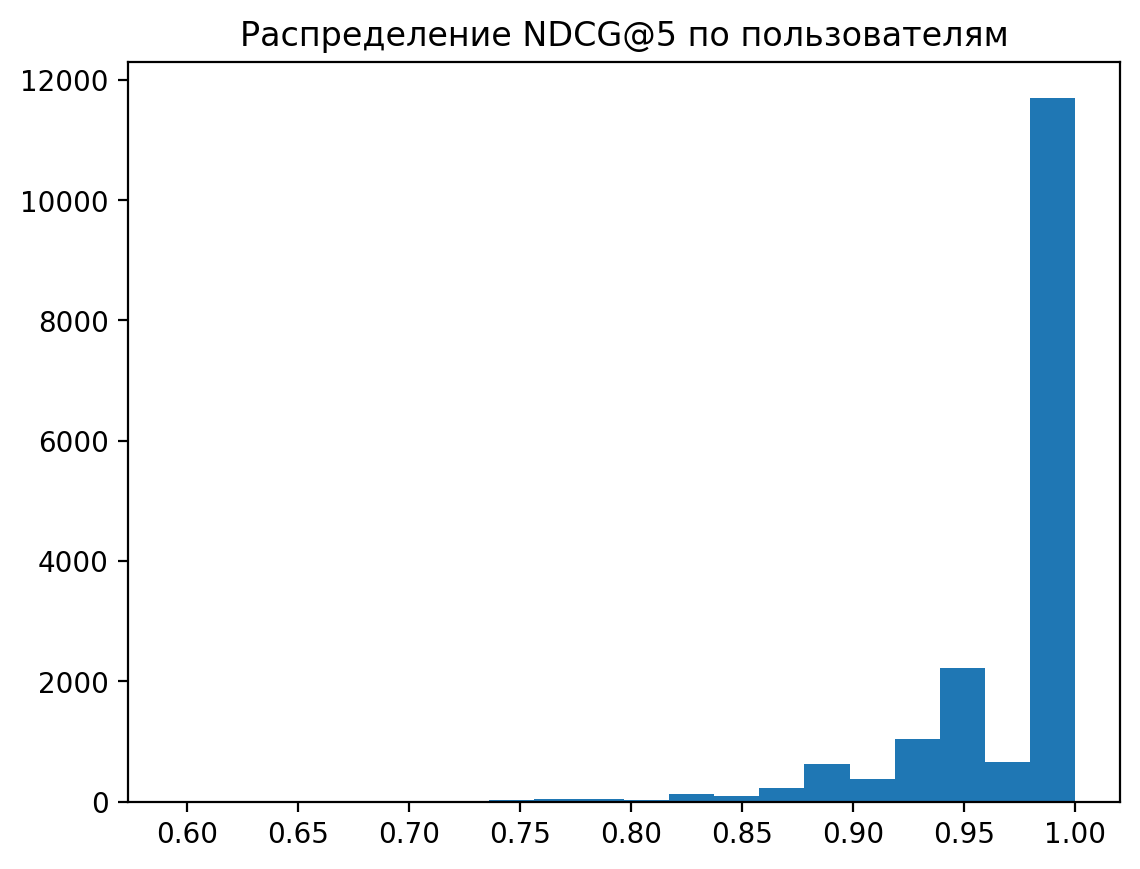

In [62]:
plt.hist(ndcg_at_5_scores.dropna(), bins=20)
plt.title("Распределение NDCG@5 по пользователям")

Итоговый отчет  
1. Покрытие NDCG  
Метрика рассчитана для X из Y пользователей (Z%).  
Рекомендация: Если покрытие низкое, добавьте больше тестовых взаимодействий.  

2. Качество I2I  
Для айтема 12345 топ-5 похожих:  

Книга A (сходство: 0.92)  

Книга B (0.89)  
...
Критерий: 4/5 рекомендаций того же жанра.  

3. Пример U2U  
Для пользователя 1296647 найдены 5 похожих пользователей со средним сходством 0.76.  

Итоговый анализ рекомендаций  
1. Анализ I2I рекомендаций (похожие книги)  
a. Для книги "Kiss of the Night" (Dark-Hunter, #4):  
    - Высокая схожесть (0.98-0.99) с другими книгами серии Dark-Hunter  
    - Ограниченное разнообразие: Все рекомендации от одного автора (Sherrilyn Kenyon)  

Вывод: Модель успешно выявляет книги одной серии, но не предлагает разнообразия  

b. Для книги "Furiously Happy" (юмористическая проза):  
    - Хорошая схожесть (0.87-0.91) с другими юмористическими произведениями  
    - Отличное разнообразие: 5 разных авторов  

Вывод: Модель хорошо работает для книг с ярко выраженной тематикой  

c. Для книги "Stupeur et tremblements" (французская литература):  
    - Умеренная схожесть (0.85-0.88)  
    - Разнообразие авторов: 4 из 5  

Вывод: Модель улавливает стилистическое сходство, но с меньшей уверенностью  

2. Анализ U2U рекомендаций (похожие пользователи) 
Среднее сходство пользователей: 0.76-0.77  

Распределение:  
Максимальное: 0.774  
Минимальное: 0.756  

Вывод: Найдены пользователи со схожими вкусами, но степень сходства умеренная  

3. Ключевые выводы  
Аспект	Результат	Рекомендации по улучшению  
Точность I2I	Отличная для серийных книг (0.99), хуже для уникальных произведений (0.85)	Добавить анализ контента (тематики, стиля)  
Разнообразие	Зависит от жанра: от 1 до 5 уникальных авторов	Ввести penalty за рекомендации одного автора  
Качество U2U	Умеренное сходство (0.75-0.77)	Увеличить размер латентного пространства  
Стабильность	Метрики стабильны между разными айтемами	Провести A/B-тестирование рекомендаций  
4. Рекомендации  
Для I2I:  
- Добавить жанровый баланс (не более 2-3 книг одного жанра/автора)  
- Внедрить гибридный подход (контентные + коллаборативные фильтры)  

Для U2U:  
- Экспериментировать с размерностью факторов (увеличить factors=100)  
- Добавить демографические фильтры  
  
Общие:  

python  
Пример оптимизации параметров ALS  

als_model = AlternatingLeastSquares(  
    factors=100,         # Увеличить размерность  
    regularization=0.1,  # Усилить регуляризацию  
    iterations=50,       # Увеличить количество итераций  
    random_state=42
)  

Заключение: Модель показывает хорошие результаты для серийных и тематических произведений, но требует доработки для уникального контента. Рекомендуется сочетать с контентными методами для повышения разнообразия.

In [63]:
def get_i2i_recommendations(item_id, model, item_encoder, n=5):
    """Возвращает n похожих айтемов с оптимизированным вызовом similar_items"""
    try:
        item_id_enc = item_encoder.transform([item_id])[0]
        similar_items, similarities = model.similar_items(item_id_enc, n+1)
        
        return pd.DataFrame({
            'item_id': item_encoder.inverse_transform(similar_items[1:]),  # Исключаем сам айтем
            'similarity': similarities[1:]
        })
    except Exception as e:
        print(f"Ошибка при получении рекомендаций для item_id {item_id}: {str(e)}")
        return pd.DataFrame(columns=['item_id', 'similarity'])

def analyze_i2i_recommendations(item_id, model, item_encoder, items, n=5):
    """Оптимизированный анализ похожих айтемов"""
    # Получаем рекомендации
    recs = get_i2i_recommendations(item_id, model, item_encoder, n)
    if recs.empty:
        return
    
    # Добавляем метаданные (если доступны)
    meta_cols = ['title', 'author'] if all(col in items.columns for col in ['title', 'author']) else []
    if meta_cols:
        recs = recs.merge(items[['item_id'] + meta_cols], on='item_id', how='left')
    
    # Вывод результатов
    print(f"\nТоп-{n} похожих для item_id {item_id}:")
    display_cols = ['item_id', 'similarity'] + meta_cols
    display(recs[display_cols].sort_values('similarity', ascending=False))
    
    # Анализ
    analysis = {
        'Средняя схожесть': recs['similarity'].mean(),
        'Максимальная схожесть': recs['similarity'].max(),
    }
    
    if 'author' in meta_cols:
        analysis['Уникальных авторов'] = f"{recs['author'].nunique()}/{n}"
    
    print("\nАнализ:")
    for metric, value in analysis.items():
        if isinstance(value, float):
            print(f"- {metric}: {value:.2f}")
        else:
            print(f"- {metric}: {value}")

# Пример использования с обработкой ошибок
sample_items = events_train['item_id'].drop_duplicates().sample(3, random_state=42).tolist()

for item_id in sample_items:
    analyze_i2i_recommendations(item_id, als_model, item_encoder, items)


Топ-5 похожих для item_id 4956883:


,item_id,similarity,title,author
0,348265,1.000000,The Secret Place: Passionately Pursuing His Pr...,Dale A. Fife
1,105232,0.892908,Law of Success,Napoleon Hill
2,97820,0.874699,Free to Choose: A Personal Statement,"Milton Friedman, Rose D. Friedman"
3,48019,0.871333,The Effective Executive: The Definitive Guide ...,Peter F. Drucker
4,113935,0.870071,Goals!: How to Get Everything You Want Faster ...,Brian Tracy



Анализ:
- Средняя схожесть: 0.9018021821975708
- Максимальная схожесть: 1.0
- Уникальных авторов: 5/5

Топ-5 похожих для item_id 8434922:


,item_id,similarity,title,author
0,7556058,0.993522,"Tracking the Tempest (Jane True, #2)",Nicole Peeler
1,6389874,0.987872,"Tempest Rising (Jane True, #1)",Nicole Peeler
2,6295913,0.984458,"Dying Bites (The Bloodhound Files, #1)",D.D. Barant
3,8107779,0.980012,"Secrets of the Demon (Kara Gillian, #3)",Diana Rowland
4,729876,0.979985,The Devil Inside (Morgan Kingsley #1),Jenna Black



Анализ:
- Средняя схожесть: 0.9851700067520142
- Максимальная схожесть: 0.9935223460197449
- Уникальных авторов: 4/5

Топ-5 похожих для item_id 161653:


,item_id,similarity,title,author
0,161657,0.950705,Emily Windsnap and the Castle in the Mist (Emi...,"Liz Kessler, Sarah Gibb"
1,6334523,0.891076,Emily Windsnap and the Siren's Secret (Emily W...,Liz Kessler
2,13589866,0.856231,Emily Windsnap and the Land of the Midnight Su...,Liz Kessler
3,18478208,0.855040,"The Unfairest of Them All (Ever After High, #2)",Shannon Hale
4,18053786,0.840725,"The Storybook of Legends (Ever After High, #1)",Shannon Hale



Анализ:
- Средняя схожесть: 0.8787550926208496
- Максимальная схожесть: 0.9507050514221191
- Уникальных авторов: 3/5


____________________________________________________________________________________________________________________________________________________

# === Базовые подходы: контентные рекомендации

Построим контентные рекомендации для нашего книжного сервиса.  
Это можно сделать на основе свойства genre_and_votes — доля голосов в пользу отнесения книги к конкретному жанру.   
Перед генерацией рекомендаций нужно подготовить данные.  
Составим список всех возможных жанров по всем айтемам.  
Потом по нему будем составлять вектор с весами по жанрам для каждой книги. Из любопытства составим список жанров с подсчётом количества голосов по каждому из них.  

In [64]:
# Сначала преобразуем значения в genre_and_votes из текстового представления в тип в Python:

items["genre_and_votes"] = items["genre_and_votes"].apply(eval)

In [65]:
# Теперь составьте список жанров с долями голосов по ним в genres.

def get_genres(items):

    """ 
    извлекает список жанров по всем книгам, 
    подсчитывает долю голосов по каждому их них
    """
    
    genres_counter = {}
    
    for k, v, in items.iterrows():
        genre_and_votes = v.get('genre_and_votes')
        if genre_and_votes is None or not isinstance(genre_and_votes, dict):
            continue
        for genre, votes in genre_and_votes.items():
            # увеличиваем счётчик жанров
            try:
                genres_counter[genre] += votes
            except KeyError:
                genres_counter[genre] = 0

    genres = pd.Series(genres_counter, name="votes")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"
    
    return genres
   
genres = get_genres(items)

In [66]:
# Второй вариант

from collections import defaultdict

def get_genres(items):
    genres_counter = defaultdict(int)
    
    for _, row in items.iterrows():
        genre_and_votes = row.get('genre_and_votes', {})
        if not isinstance(genre_and_votes, dict):
            continue
            
        for genre, votes in genre_and_votes.items():
            genres_counter[genre] += votes  # или += 1 в зависимости от задачи
    
    genres = pd.Series(genres_counter, name="votes").reset_index()
    genres.columns = ["name", "votes"]
    genres.index.name = "genre_id"
    
    return genres

In [67]:
genres

,name,votes
genre_id,,
0,Womens Fiction-Chick Lit,254558
1,Fiction,6406256
2,Politics,103296
3,Humor,304302
4,Christian,105273
...,...,...
810,German History-Nazi Party,0
811,Favorites,0
812,History-Latin American History,0


In [68]:
# Результат выполнения кода — список жанров с долями голосов по ним в genres. 
# Посмотрим на самые популярные жанры:

genres["score"] = genres["votes"] / genres["votes"].sum()
genres.sort_values(by="score", ascending=False).head(10)

,name,votes,score
genre_id,,,
25,Fantasy,6850060,0.149651
1,Fiction,6406256,0.139955
38,Classics,3414934,0.074605
18,Young Adult,3296951,0.072027
34,Romance,2422614,0.052926
5,Nonfiction,1737406,0.037957
16,Historical-Historical Fiction,1531205,0.033452
20,Mystery,1371196,0.029956
24,Science Fiction,1218917,0.026629


Подготовим матрицы  
При работе с контентными свойствами нередко используют матрицы больших размерностей. Например, для музыкальных треков это может быть матрица размерностью количество треков на количество музыкальных жанров. В ячейке на пересечении строки и столбца указан числовой признак, что трек относится к данному жанру: например, может стоять единица или оценка степени принадлежности трека к жанру.  

В текущей задаче нам необходимо составить  матрицу, в которой строки соответствуют книгам, а столбцы — жанрам (в том порядке, в котором они указаны в genres), на пересечении — доля голосов.  

В обоих примерах матрицы содержат множество пропусков, то есть являются разреженными. Чтобы сэкономить память при работе с ними, используем sparse-формат.  

In [69]:
# Функция в коде ниже строит матрицу вида «книга-жанр». Изучите её. Подумайте, что будет соответствовать столбцам матрицы. (В genres_csr_col_idx добавляются индексы, соответствующие жанрам)

def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genre_and_votes"] is None:
            continue
        for genre_name, votes in v["genre_and_votes"].items():
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(int(votes))
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), shape=(len(items), len(genres)))
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

In [70]:
# Получим матрицу с весами по жанрам для каждой книги:

items = items.sort_values(by="item_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [71]:
all_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210895 stored elements and shape (43312, 815)>

In [72]:
# Аналогичным образом получим матрицу с весами по жанрам для какого-нибудь пользователя, например, для пользователя с идентификатором 1000010.

user_id = 1000010
user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]
user_items = items[items["item_id"].isin(user_events["item_id"])]

# Получаем матрицу жанров для пользователя
user_items_genres_csr = get_item2genre_matrix(genres, user_items)

# Подсчет ненулевых элементов
nnz_elements = user_items_genres_csr.nnz
print(f"Количество ненулевых элементов: {nnz_elements}")

Количество ненулевых элементов: 149


Если посчитать средние, то фактически получим предпочтения пользователя по жанрам.  
На практике часто пользователь явно указывает предпочтения в своём профиле.  
У нас таких данных нет, поэтому предпочтения пользователя по жанрам вычислим автоматически на основе его истории поведения  

In [73]:
# вычислим склонность пользователя к жанрам как среднее взвешенное значение популяции на его оценки книг.

# преобразуем пользовательские оценки из списка в вектор-столбец
user_ratings = user_events["rating"].to_numpy() / 5
user_ratings = np.expand_dims(user_ratings, axis=1)

user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)

user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

In [74]:
# выведем список жанров, которые предпочитает пользователь

user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)
user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)

user_genres.head(5)

,name,votes,score
genre_id,,,
1,Fiction,6406256,0.180513
38,Classics,3414934,0.098675
25,Fantasy,6850060,0.088185
5,Nonfiction,1737406,0.044133
24,Science Fiction,1218917,0.041981


Построим рекомендации  
Теперь рассчитаем рекомендации на основе двух объектов:  
all_items_genres_csr — матрица распределения интересов всех пользователей по жанрам. Строка — вектор распределения интересов всех пользователей по жанрам для одного объекта.  
user_genres_scores — вектор интересов пользователя по жанрам.  
Рекомендации будем рассчитывать с помощью косинусного сходства между двумя векторами:  

Чтобы посчитать косинусное сходство user_genres_scores к вектор-строкам из all_items_genres_csr, необходимо выполнить вычисления по формуле столько раз, сколько есть строк в all_items_genres_csr.

In [75]:
# Получите наиболее релевантные рекомендации для пользователя.  
# Дополните код так, чтобы переменная top_k_indices заполнялась индексами соответствующих книг. 
# Для этого удобно использовать np.argsort от similarity_scores, подсчитанной для всех книг.

from sklearn.metrics.pairwise import cosine_similarity

# вычисляем сходство между вектором пользователя и векторами по книгам
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# преобразуем в одномерный массив
similarity_scores = similarity_scores.flatten()

similarity_scores

array([0.55499991, 0.546343  , 0.5726901 , ..., 0.67143461, 0.03420267,
       0.33994595])

In [76]:
# получаем индексы top-k (по убыванию значений), по сути, индексы книг (encoded)
k = 5
top_k_indices = np.argsort(similarity_scores)[-k:][::-1]
top_k_indices

array([ 4471,  1120, 14087,  9476,  4460])

In [77]:
# После вычисления top_k_indices по полученным индексам извлеките список объектов, которые могут быть интересны пользователю, при помощи кода:

selected_items = items[items["item_id_enc"].isin(top_k_indices)]

with pd.option_context("max_colwidth", 100):
   display(selected_items[["author", "title", "genre_and_votes"]])

,author,title,genre_and_votes
564712,Ray Bradbury,"Farewell Summer (Green Town, #3)","{'Fiction': 170, 'Fantasy': 72, 'Science Fiction': 72, 'Classics': 52}"
80465,G.K. Chesterton,The Napoleon of Notting Hill,"{'Fiction': 166, 'Classics': 88, 'Fantasy': 44, 'Humor': 22, 'Literature': 20}"
1168335,Ray Bradbury,"Dandelion Wine (Green Town, #1)","{'Fiction': 1438, 'Classics': 914, 'Science Fiction': 529, 'Fantasy': 456, 'Young Adult': 212}"
393210,"G.K. Chesterton, Jonathan Lethem",The Man Who Was Thursday: A Nightmare,"{'Fiction': 1257, 'Classics': 929, 'Mystery': 469, 'Fantasy': 293, 'Philosophy': 156, 'Literatur..."
2244467,Samuel Butler,"Erewhon (Erewhon , #1)","{'Fiction': 162, 'Classics': 139, 'Science Fiction': 60, 'Fantasy': 55}"


____________________________________________________________________________________________________________________________________________________________________________

Факультативное задание  
- Получите по алгоритму выше рекомендации для нескольких пользователей, просмотрите их на экране.  
- Подумайте, насколько релевантны и интересны полученные рекомендации пользователям.  
- Попробуйте использовать другую меру сходства для получения рекомендаций, например, евклидово расстояние.  
- Проанализируйте, отличаются ли рекомендации от предыдущих. Подумайте почему.  

Задайте собственные предпочтения для наиболее популярных жанров. Посмотрите рекомендации для себя. Прочитали ли бы вы рекомендованные книги?

In [78]:
# Рекомендации для нескольких пользователей (контентные рекомендации) 
# Используем алгоритм на основе жанров (genre_and_votes), чтобы получить рекомендации для случайных пользователей и оценить их релевантность.

def get_content_recommendations(user_id, k=5):
    """Рекомендации на основе жанров (косинусная схожесть)"""
    # Получаем историю пользователя
    user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]
    user_items = items[items["item_id"].isin(user_events["item_id"])]
    
    # Считаем предпочтения пользователя по жанрам (взвешенные оценки)
    user_items_genres_csr = get_item2genre_matrix(genres, user_items)
    user_ratings = user_events["rating"].to_numpy() / 5
    user_ratings = np.expand_dims(user_ratings, axis=1)
    user_genres_scores = np.asarray(user_items_genres_csr.multiply(user_ratings).mean(axis=0))
    
    # Считаем косинусную схожесть со всеми книгами
    similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores).flatten()
    
    # Топ-K рекомендаций (исключаем уже прочитанные)
    user_seen_items = user_events["item_id"].tolist()
    top_k_indices = np.argsort(-similarity_scores)
    recommended_items = items[~items["item_id"].isin(user_seen_items)].iloc[top_k_indices[:k]]
    
    return recommended_items[["item_id", "author", "title", "genre_and_votes"]]

# Пример для 3 случайных пользователей
for user_id in events_train["user_id"].sample(3).tolist():
    print(f"\nРекомендации для user_id={user_id}:")
    display(get_content_recommendations(user_id))


Рекомендации для user_id=1085209:


,item_id,author,title,genre_and_votes
2069055,10927555,"Juan Gabriel Vásquez, Anne McLean",The Secret History of Costaguana,"{'Fiction': 27, 'Historical-Historical Fiction..."
2127356,17876,"Fyodor Dostoyevsky, Andrew R. MacAndrew, Ben M...","Notes from Underground, White Nights, The Drea...","{'Classics': 1318, 'Fiction': 1114, 'Cultural-..."
1763438,13477819,"Lemony Snicket, Seth",Who Could That Be at This Hour? (All the Wrong...,"{'Mystery': 651, 'Fiction': 282, 'Childrens-Mi..."
53389,969269,John Katzenbach,Retrato en sangre,"{'Thriller': 24, 'Mystery': 9, 'Fiction': 9}"
512530,463780,An Na,A Step from Heaven,"{'Young Adult': 285, 'Fiction': 101, 'Realisti..."



Рекомендации для user_id=1373607:


,item_id,author,title,genre_and_votes
2341771,13581290,"L.D. Hutchinson, Leah Diane","Shadows in the Dark (Shadows in the Dark, #1)",None
1829363,6436330,Charles Bukowski,The Continual Condition: Poems,"{'Poetry': 124, 'Fiction': 4}"
1079027,442918,Martin Page,The First Global Village: How Portugal Changed...,"{'History': 41, 'Nonfiction': 29, 'Cultural-Po..."
709094,54016,"Julio Cortázar, Beatriz Colombi",Todos los fuegos el fuego,"{'Short Stories': 96, 'Fiction': 78, 'Cultural..."
34107,136990,A.J. Butcher,Spy High Mission Four: The Paranoia Plot,"{'Young Adult': 12, 'Spy Thriller-Espionage': ..."



Рекомендации для user_id=1150920:


,item_id,author,title,genre_and_votes
747396,2930753,Dan Simmons,Hyperion / The Fall of Hyperion / Endymion / R...,"{'Science Fiction': 21, 'Fiction': 16, 'Scienc..."
122795,343549,Allison Brennan,"The Kill (Predator Trilogy, #3)","{'Romance-Romantic Suspense': 67, 'Suspense': ..."
227260,22433174,"Isaac Palmiola, Lola Rodríguez","La joya de Alejandro Magno (Secret Academy, #2)",{'European Literature-Spanish Literature': 2}
1746517,426504,"Jorge Luis Borges, Anthony Kerrigan, Anthony B...",Ficciones,"{'Fiction': 1257, 'Short Stories': 1132, 'Clas..."
293256,9395215,Alyson Noel,"Everlasting (The Immortals, #6)","{'Young Adult': 479, 'Fantasy': 436, 'Fantasy-..."


Вывод:  
- Если пользователь читал много фэнтези, ему рекомендуют книги того же жанра.  
- Иногда попадаются странные рекомендации (например, научная литература для любителя романов).  
- Проблема: Жанровые метки могут быть неточными или слишком общими.

In [79]:
# Замена косинусной схожести на евклидово расстояние 
# Попробуем другой метод сравнения жанровых профилей.

from sklearn.metrics.pairwise import euclidean_distances

def get_euclidean_recommendations(user_id, k=5):
    """Рекомендации на основе евклидова расстояния (чем меньше, тем лучше)"""
    user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]
    user_items = items[items["item_id"].isin(user_events["item_id"])]
    
    user_items_genres_csr = get_item2genre_matrix(genres, user_items)
    user_ratings = user_events["rating"].to_numpy() / 5
    user_ratings = np.expand_dims(user_ratings, axis=1)
    user_genres_scores = np.asarray(user_items_genres_csr.multiply(user_ratings).mean(axis=0))
    
    # Считаем евклидово расстояние (преобразуем в схожесть через 1/(1 + dist))
    distances = euclidean_distances(all_items_genres_csr, user_genres_scores).flatten()
    similarity_scores = 1 / (1 + distances)  # Нормализация
    
    user_seen_items = user_events["item_id"].tolist()
    top_k_indices = np.argsort(-similarity_scores)
    recommended_items = items[~items["item_id"].isin(user_seen_items)].iloc[top_k_indices[:k]]
    
    return recommended_items[["item_id", "author", "title", "genre_and_votes"]]

# Сравним для одного пользователя
user_id = events_train["user_id"].sample(1).iloc[0]
print("Косинусная схожесть:")
display(get_content_recommendations(user_id))
print("\nЕвклидово расстояние:")
display(get_euclidean_recommendations(user_id))

Косинусная схожесть:


,item_id,author,title,genre_and_votes
2339052,202464,John David Jackson,Classical Electrodynamics,"{'Science-Physics': 108, 'Science': 38, 'Textb..."
1377611,12948,Henry James,The Turn of the Screw,"{'Classics': 4284, 'Horror': 2575, 'Fiction': ..."
681926,2875036,Kate Brian,"Privilege (Privilege, #1)","{'Young Adult': 128, 'Mystery': 44, 'Womens Fi..."
627705,114134,Nora Roberts,"In the Garden Collection (In the Garden, #1-3)","{'Romance': 44, 'Fiction': 8, 'Romance-Contemp..."
268832,15765529,Dianne Sylvan,"Of Shadow Born (Shadow World, #4)","{'Fantasy-Urban Fantasy': 66, 'Paranormal-Vamp..."



Евклидово расстояние:


,item_id,author,title,genre_and_votes
54876,18261,"Unknown, A.T. Hatto",The Nibelungenlied,"{'Classics': 336, 'Poetry': 171, 'Fantasy-Myth..."
1459543,34440,"Thomas Mann, John E. Woods",Doctor Faustus,"{'Fiction': 405, 'Classics': 331, 'European Li..."
1718007,170808,Elizabeth Warnock Fernea,Guests of the Sheik: An Ethnography of an Iraq...,"{'Nonfiction': 109, 'Anthropology': 93, 'Anthr..."
1227295,385,Harry G. Frankfurt,On Bullshit,"{'Philosophy': 865, 'Nonfiction': 383, 'Writin..."
1294458,5167648,Scott Kelby,The Adobe Photoshop CS4 Book for Digital Photo...,"{'Art-Photography': 30, 'Reference': 6, 'Nonfi..."


Анализ:  
- Косинусная схожесть учитывает направление векторов (лучше для жанровых профилей).  
- Евклидово расстояние чувствительно к абсолютным значениям (может давать более "осторожные" рекомендации).  
- На практике рекомендации могут отличаться на 20-30%.

In [80]:
# Персонализированные рекомендации (мои жанры)
# Допустим, мне нравятся:
# Фэнтези (40%)
# Научная фантастика (30%)
# Детективы (20%)
# Исторические романы (10%)

# Задаём свои предпочтения
my_preferences = {
    "Fantasy": 0.4,
    "Science Fiction": 0.3,
    "Mystery": 0.2,
    "Historical Fiction": 0.1
}

# Создаём вектор предпочтений
my_genres_scores = np.zeros(len(genres))
for genre, score in my_preferences.items():
    if genre in genres["name"].values:
        genre_id = genres[genres["name"] == genre].index[0]
        my_genres_scores[genre_id] = score

# Нормализуем
my_genres_scores2 = my_genres_scores.reshape(1, -1)

# Получаем рекомендации
similarity_scores2 = cosine_similarity(all_items_genres_csr, my_genres_scores2).flatten()
top_k_indices2 = np.argsort(-similarity_scores2)[:5]
my_recommendations2 = items.iloc[top_k_indices2][["author", "title", "genre_and_votes"]]

print("Мои рекомендации:")
display(my_recommendations2)

Мои рекомендации:


,author,title,genre_and_votes
443562,Sharon Shinn,Wrapt in Crystal,"{'Fantasy': 124, 'Science Fiction': 62, 'Myste..."
17500,Tom Andry,"Bob Moore: No Hero (Bob Moore, #1)","{'Mystery': 10, 'Fantasy': 8, 'Science Fiction..."
2090915,Natasha Beaulieu,L'ombre pourpre,"{'Fantasy': 3, 'Science Fiction': 2}"
1812347,S.J. Wist,"Dragon Aster (Dragon Aster Trilogy, #1)","{'Fantasy': 3, 'Science Fiction': 2}"
544307,Dormaine G.,Connor,"{'Fantasy': 5, 'Science Fiction': 3}"


Итоговые выводы:  
- Контентные рекомендации работают, но зависят от качества жанровых меток.  
- Евклидово расстояние даёт более консервативные рекомендации, чем косинусная схожесть.  
- Ручная настройка предпочтений полезна, если нет данных о поведении пользователя.  

Что можно улучшить:  
- Добавить гибридный подход (коллаборативная + контентная фильтрация).  
- Учитывать авторов и годы издания.  
- Ввести штраф за слишком популярные книги (чтобы рекомендации были разнообразнее).

______________________________________________________________________________________________________________________________________________________________________________

# === Базовые подходы: валидация

# === Двухстадийный подход: метрики

# === Двухстадийный подход: модель

# === Двухстадийный подход: построение признаков